## 1分間雨量から積算雨量の時系列を計算しnetcdfで出力するスクリプト
* 入力: cress データ

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader
import xarray as XR
import metpy
from metpy.units import units
import metpy.calc as mpcalc
#from mpl_toolkits.basemap import cm
import sys # to get argv
import os
import warnings
warnings.filterwarnings('ignore')

In [137]:
exp = 'AW-H'
exp = 'AVW-H'
exp = 'AVW-H-LNA'
exp = 'AVW-H-LKO'
nc1 = f'/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/cress/{exp}/CReSS.nc'

xmin, xmax, ymin, ymax = 130.0, 132.0, 32.0, 32.2 # 可視化領域の設定
xmin, xmax, ymin, ymax = 130.5, 131.1, 32.0, 32.2 # 可視化領域の設定
#xr1  = XR.open_mfdataset(nc1).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))#.sel(TIME=t)
xr1  = XR.open_dataset(nc1).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))#.sel(TIME=t)

vmin = 0; vmax = 70; cmap = "rainbow" 
p = xr1["PA1MIN"]
#p = xr1["PA1MIN"].isel(TIME=121)
#a = p.data
#np.unravel_index(np.argmax(a), a.shape)

#p.isel(p.argmax(dim=["LON","LAT"])) # open_dataset で xarrayとして読み込んだらうまくいくが、 open_mfdataset で dask_array として読み込むとうまくいかない。dask_array=>xarrayの方法を後で調べるべし。
#a.isel(a.argmax(dim=["x", "z"]))
#p

In [138]:
def calc_accum(da):
    def set_attrs(var):
        var.attrs["units"] = "mm"
        var.attrs["long_name"] = "Accumulated rainfall"    

    da_ou  = da.copy()
       
    var_in = da.data
    var_ou = var_in
    var_ou[0,:,:] = 0.0 # 初期時刻の積算雨量は 0 mm であるので、0を代入
    tpa = 0.0
    nt = da["TIME"].size
    for i in range(1,nt):
        tpa = tpa + var_in[i]
        var_ou[i,:,:] = tpa
    da_ou[:,:,:] =  var_ou
    set_attrs(da_ou)
    da_ou = da_ou.rename("TPA")
    return da_ou

In [139]:
tpa = calc_accum(p)

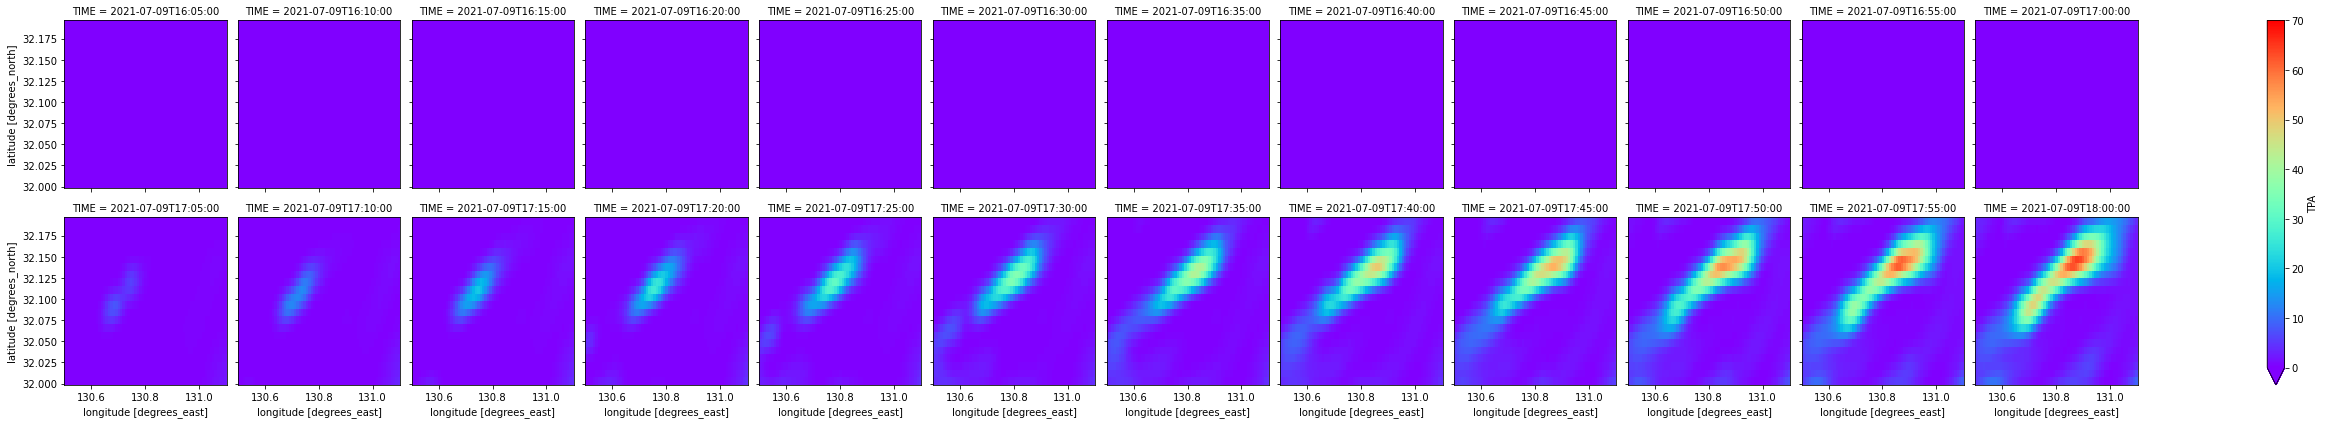

In [140]:
t0 = "2021-07-09T16:00" # 16:05 UTC = 01:05 JST
t1 = "2021-07-09T16:05" # 16:05 UTC = 01:05 JST
tm = "2021-07-09T17:00" # 17:00 UTC = 02:00 JST
t2 = "2021-07-09T18:00" # 18:00 UTC = 03:00 JST

tpa2   = tpa - tpa.sel(TIME=tm)
tpa2_s = tpa2.sel(TIME=slice(t1, t2, 5))
tpa_s  = tpa.sel(TIME=slice(t1, t2, 5))

vmin2 = 0; vmax2 = 70; cmap = "rainbow" 
(tpa2_s).plot(cmap=cmap, vmin=vmin2, vmax=vmax2, x="LON", y="LAT", col="TIME", col_wrap=12)
#(tpa_s).plot(cmap=cmap, vmin=vmin2, vmax=vmax2, x="LON", y="LAT", col="TIME", col_wrap=12)


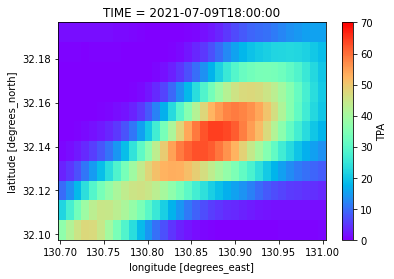

In [141]:
xmin, xmax, ymin, ymax = 130.6, 130.8, 32.05, 32.15 # 可視化領域の設定
xmin, xmax, ymin, ymax = 130.7, 131.0, 32.10, 32.20 # 可視化領域の設定

tpa2_local = tpa2.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
tpa2_local.sel(TIME=t2).plot(cmap=cmap, vmin=vmin2, vmax=vmax2)

In [142]:
#maxloc = pppp.argmax(dim=["LON","LAT"])
a = tpa2_local.sel(TIME=t2).data
b = np.unravel_index(np.argmax(a), a.shape)

tpa_local = tpa.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
#tpa2 = tpa.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

tpa_maxloc = tpa_local[:,b[0],b[1]]
tpa2_maxloc = tpa2_local[:,b[0],b[1]]#
tpa_maxloc.max()


#a = da2d.data
#b = np.unravel_index(np.argmax(a), a.shape)


<xarray.DataArray 'TPA' ()>
array(65.19001, dtype=float32)
Coordinates:
    LAT      float64 32.15
    LON      float64 130.9

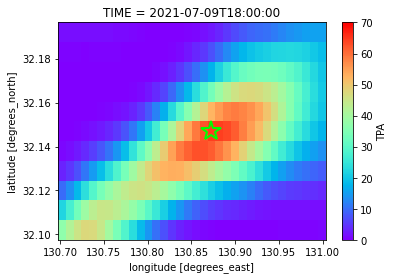

In [143]:
x = tpa2_local.sel(TIME=t2)
a = x.data
b = np.unravel_index(np.argmax(a), a.shape)
lat = x.coords["LAT"]
lon = x.coords["LON"]

lat_max = lat[b[0]] 
lon_max = lon[b[1]]

x.plot(cmap=cmap, vmin=vmin2, vmax=vmax2)
plt.plot(lon_max, lat_max, marker='*', color='lime', markersize=20, fillstyle='none', mew=2)

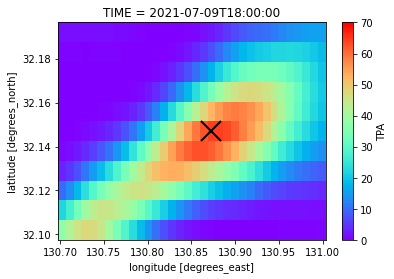

In [144]:
x = tpa2_local.sel(TIME=t2)
lat = x.coords["LAT"]
lon = x.coords["LON"]
maxloc = x.argmax(dim=["LON","LAT"])
lon_max = lon[maxloc["LON"].data]
lat_max = lat[maxloc["LAT"].data]
x.plot(cmap=cmap, vmin=vmin2, vmax=vmax2)
plt.plot(lon_max, lat_max, marker='x', color='black', markersize=20, fillstyle='none', mew=2)

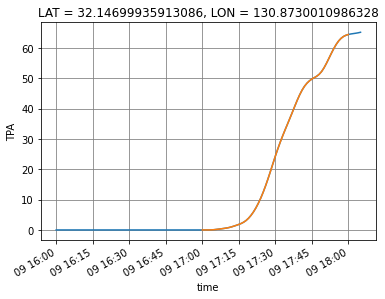

In [145]:
#tpa_maxloc.plot()
tpa2_maxloc.plot()
tpa2_maxloc.sel(TIME=slice(tm, t2)).plot()

plt.grid(which='major',color='gray',linestyle='-')

In [146]:
tpa2_maxloc.to_netcdf(f"TPA_{exp}.nc")
#tpa2_maxloc.to_netcdf(f"TPA_{exp}2.nc")